In [30]:
import pandas as pd
import numpy as np

In [31]:
df = pd.read_csv('Twitter_volume_AAPL.csv')
df.head()

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120


In [32]:
df.shape

(15902, 2)

# Analisis presentile

In [33]:
percentile_95 = np.percentile(df['value'], 95, method='median_unbiased')
percentile_5 = np.percentile(df['value'], 5, method='median_unbiased')
greater_than_95 = (df[['value']] > percentile_95)
smaller_than_5 = (df[['value']] < percentile_5)

In [34]:
 #Membuat kolom baru dengan nama colors untuk menyimpan warna setiap kondisi diatas
df['colors'] = np.where(greater_than_95,'r',np.where(smaller_than_5,'r','b'))

In [35]:
# Mengasumsikan df memiliki lebih dari 1000 kolom
df = df.head(100)
df.shape

(100, 3)

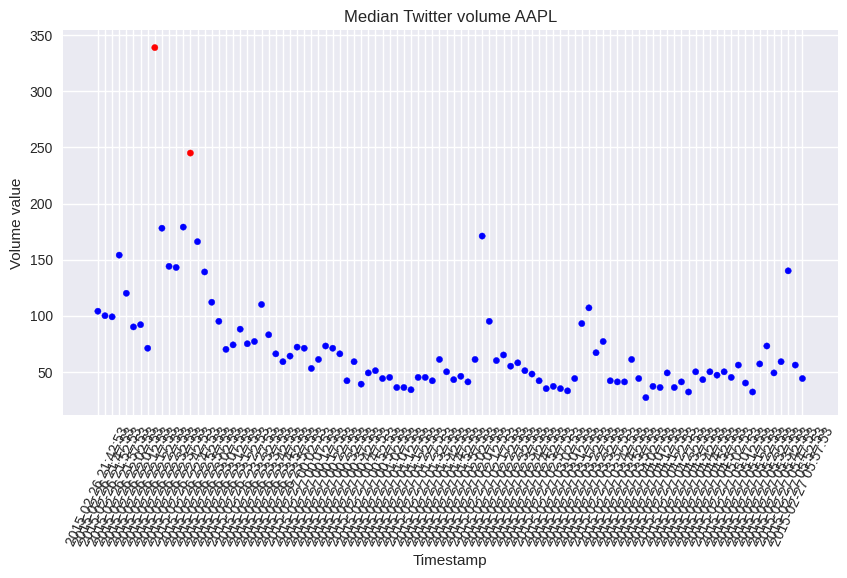

In [36]:
import matplotlib.pyplot as plt
df.plot.scatter(x='timestamp',y='value',c = df['colors'].apply(lambda x: dict(r='red', b='blue')[x]),
           figsize=(10, 5),title='Median Twitter volume AAPL',xlabel='Timestamp',ylabel='Volume value')
plt.xticks(rotation=65);

# Analisis regresi

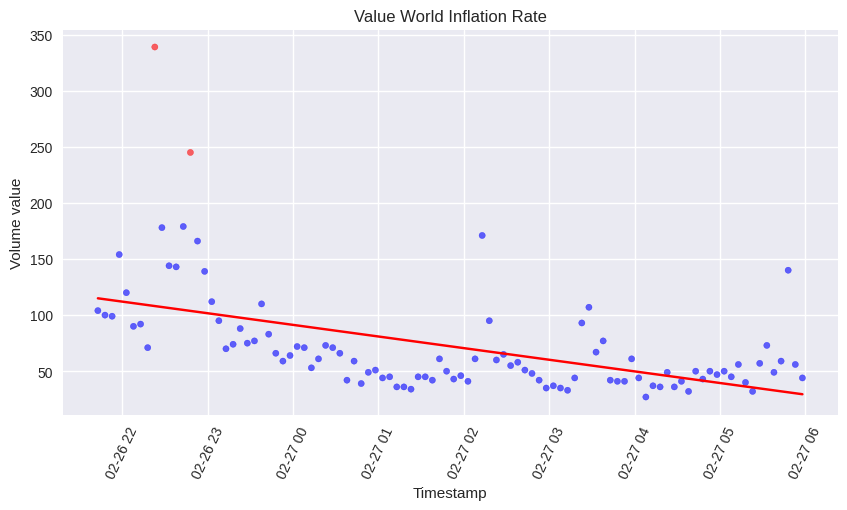

In [37]:
# Pendekatan Statistik dengan Analisis Regresi
from sklearn.linear_model import LinearRegression

# Mengonversi kolom 'timestamp' menjadi tipe data datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Mengonversi timestamp ke dalam bentuk numerik (timestamp sebagai detik sejak epoch)
df['timestamp_numeric'] = df['timestamp'].astype(int) // 10**9

# Membuat model regresi linear
LinearRegression_model = LinearRegression()
LinearRegression_model.fit(df[['timestamp_numeric']], df[['value']])

# Plotting dengan nama kolom yang diubah pada tampilan grafik
ax = df.plot.scatter(x='timestamp', y='value',
                     c=df['colors'].apply(lambda x: dict(r='red', b='blue')[x]),
                     alpha=.6, figsize=(10, 5),
                     title='Value World Inflation Rate', xlabel='Timestamp', ylabel='Volume value')
reg_prediction = LinearRegression_model.predict(df[['timestamp_numeric']])
ax.plot(df['timestamp'], reg_prediction, c='r')
plt.xticks(rotation=65)
plt.show()


Terlihat bahwa ada banyak titik yang jauh dari garis regresi. Titik-titik ini berpotensi dianggap outlier jika menggunakan metode berbasis jarak, namun model linier gagal menangkap pola dasar data secara akurat. Akibatnya, sulit untuk mengidentifikasi anomali nyata secara tepat menggunakan regresi linier sederhana.

# Pendekatan Unsupervised dengan Local Outlier  Factor (LOF)

In [38]:
from sklearn.neighbors import LocalOutlierFactor
model_LOF = LocalOutlierFactor()
LOF_predictions = model_LOF.fit_predict(df[['value']])
model_LOF_scores = model_LOF.negative_outlier_factor_
df['LOF_anomaly_scores'] = model_LOF_scores
df['LOF_anomaly'] = LOF_predictions

<ipython-input-39-96a09909fdca>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


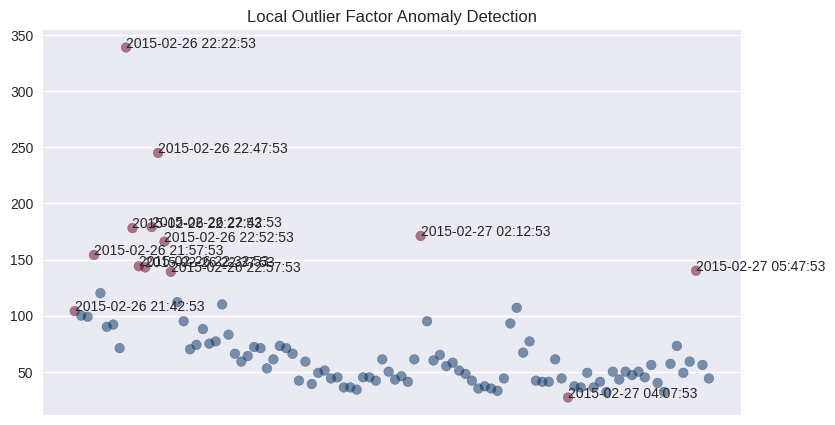

In [39]:
plt.style.use("seaborn")
fig, ax = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax.scatter(df['timestamp'], df['value'],c=df['LOF_anomaly'],cmap='RdBu',alpha=0.5 )
ax.set_title("Local Outlier Factor Anomaly Detection")

for anomaly in df[df['LOF_anomaly'] == -1]['timestamp']:
    ax.annotate(anomaly, xy=(anomaly, df[df['timestamp'] == anomaly]['value']),
                 xytext=(anomaly,df[df['timestamp'] == anomaly]['value'] + 0.2))
ax.get_xaxis().set_visible(False)

In [40]:
# Menampilkan jumlah data yang dianggap sebagai anomali
jumlah_anomali_LOF = len(df[df['LOF_anomaly'] == -1])
print(f"Jumlah data anomali berdasarkan LOF: {jumlah_anomali_LOF}")

Jumlah data anomali berdasarkan LOF: 13


In [41]:
model_LOF_10 = LocalOutlierFactor(n_neighbors=10)
LOF_predictions_10 = model_LOF_10.fit_predict(df[['value']])
model_LOF_scores_10= model_LOF_10.negative_outlier_factor_
df['LOF_anomaly_score_10'] = model_LOF_scores_10
df['LOF_anomaly_10'] = LOF_predictions_10

<ipython-input-42-501201f11f95>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


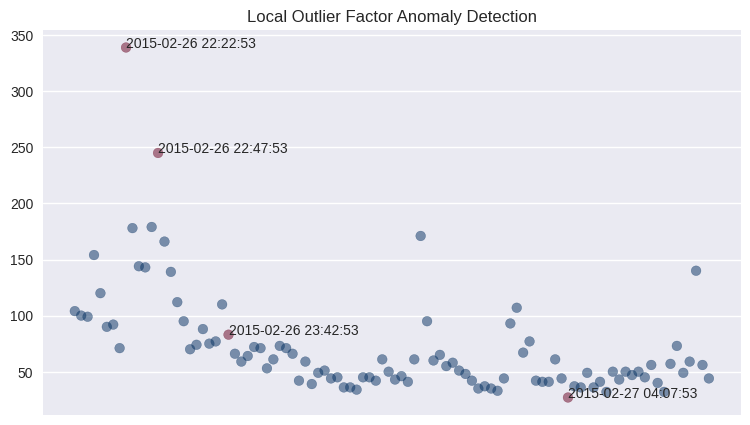

In [42]:
plt.style.use("seaborn")
fig, ax2 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax2.scatter(df['timestamp'], df['value'],c=df['LOF_anomaly_10'],cmap='RdBu',alpha=0.5 )
ax2.set_title("Local Outlier Factor Anomaly Detection")

for anomaly in df[df['LOF_anomaly_10'] == -1]['timestamp']:
    ax2.annotate(anomaly, xy=(anomaly, df[df['timestamp'] == anomaly]['value']),
                 xytext=(anomaly,df[df['timestamp'] == anomaly]['value'] + 0.2))
ax2.get_xaxis().set_visible(False)

In [55]:
# Menampilkan jumlah data yang dianggap sebagai anomali
jumlah_anomali_LOF = len(df[df['LOF_anomaly_10'] == -1])
print(f"Jumlah data anomali berdasarkan LOF: {jumlah_anomali_LOF}")

Jumlah data anomali berdasarkan LOF: 4


# Pendekatan dengan algoritma ISOLATION FORREST

In [44]:
from sklearn.ensemble import IsolationForest
model_IF = IsolationForest()
model_IF.fit(df[['value']])
df['IF_anomaly_scores'] = model_IF.decision_function(df[['value']])
df['IF_anomaly'] = model_IF.predict(df[['value']])

<ipython-input-45-5650df411a1e>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


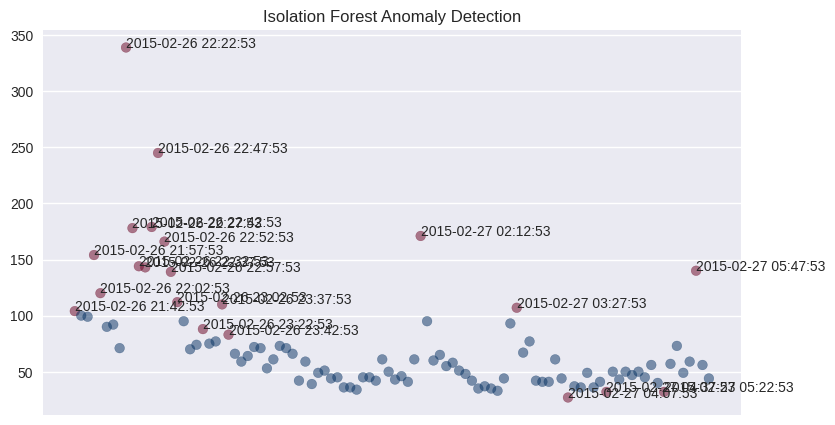

In [45]:
plt.style.use("seaborn")
fig, ax3 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax3.scatter(df['timestamp'], df['value'],c=df['IF_anomaly'],cmap='RdBu',alpha=0.5 )
ax3.set_title("Isolation Forest Anomaly Detection")

for anomaly in df[df['IF_anomaly'] == -1]['timestamp']:
    ax3.annotate(anomaly, xy=(anomaly, df[df['timestamp'] == anomaly]['value']),
                 xytext=(anomaly,df[df['timestamp'] == anomaly]['value'] + 0.2))
ax3.get_xaxis().set_visible(False)

In [56]:
# Menampilkan jumlah data yang dianggap sebagai anomali
jumlah_anomali_LOF = len(df[df['IF_anomaly'] == -1])
print(f"Jumlah data anomali berdasarkan IF: {jumlah_anomali_LOF}")

Jumlah data anomali berdasarkan IF: 21


In [47]:
model_IF_05 = IsolationForest(contamination=float(.05))
model_IF_05.fit(df[['value']])
df['IF_anomaly_scores_05'] = model_IF_05.decision_function(df[['value']])
df['IF_anomaly_05'] = model_IF_05.predict(df[['value']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<ipython-input-48-6ae92268a6a2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


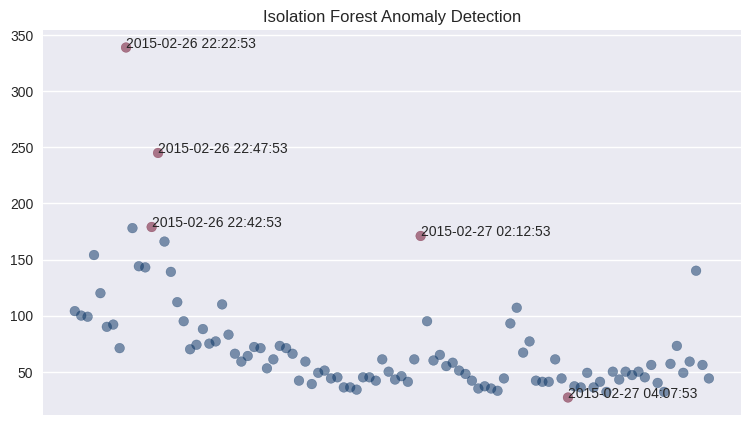

In [48]:
plt.style.use("seaborn")
fig, ax4 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax4.scatter(df['timestamp'], df['value'],c=df['IF_anomaly_05'],cmap='RdBu',alpha=0.5 )
ax4.set_title("Isolation Forest Anomaly Detection")

for anomaly in df[df['IF_anomaly_05'] == -1]['timestamp']:
    ax4.annotate(anomaly, xy=(anomaly, df[df['timestamp'] == anomaly]['value']),
                 xytext=(anomaly,df[df['timestamp'] == anomaly]['value'] + 0.2))
ax4.get_xaxis().set_visible(False)

In [57]:
# Menampilkan jumlah data yang dianggap sebagai anomali
jumlah_anomali_LOF = len(df[df['IF_anomaly_05'] == -1])
print(f"Jumlah data anomali berdasarkan IF: {jumlah_anomali_LOF}")

Jumlah data anomali berdasarkan IF: 5


# Pendekatan dengan algoritma OneClassSVM

<ipython-input-50-c7a91c2d0703>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


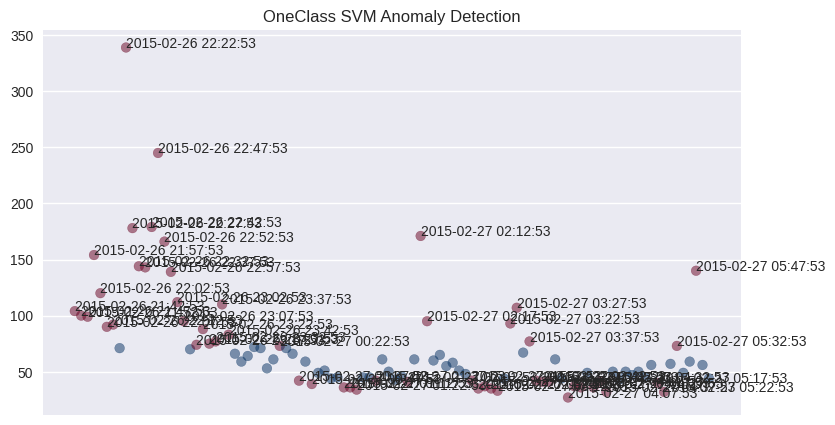

In [50]:
from sklearn.svm import OneClassSVM

# Pendekatan dengan algoritma OneClass SVM
model_SVM = OneClassSVM()
model_SVM.fit(df[['value']])
df['SVM_anomaly'] = model_SVM.predict(df[['value']])

# Menampilkan Scatter Plot dengan Warna Berdasarkan Anomali OneClass SVM
plt.style.use("seaborn")
fig, ax5 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax5.scatter(df['timestamp'], df['value'], c=df['SVM_anomaly'], cmap='RdBu', alpha=0.5)
ax5.set_title("OneClass SVM Anomaly Detection")
for anomaly in df[df['SVM_anomaly'] == -1]['timestamp']:
    ax5.annotate(anomaly, xy=(anomaly, df[df['timestamp'] == anomaly]['value']),
                 xytext=(anomaly, df[df['timestamp'] == anomaly]['value'] + 0.2))
ax5.get_xaxis().set_visible(False)


In [58]:
# Menampilkan jumlah data yang dianggap sebagai anomali
jumlah_anomali_LOF = len(df[df['SVM_anomaly'] == -1])
print(f"Jumlah data anomali berdasarkan OCSVM: {jumlah_anomali_LOF}")

Jumlah data anomali berdasarkan OCSVM: 54


<ipython-input-52-cbe853dd7752>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


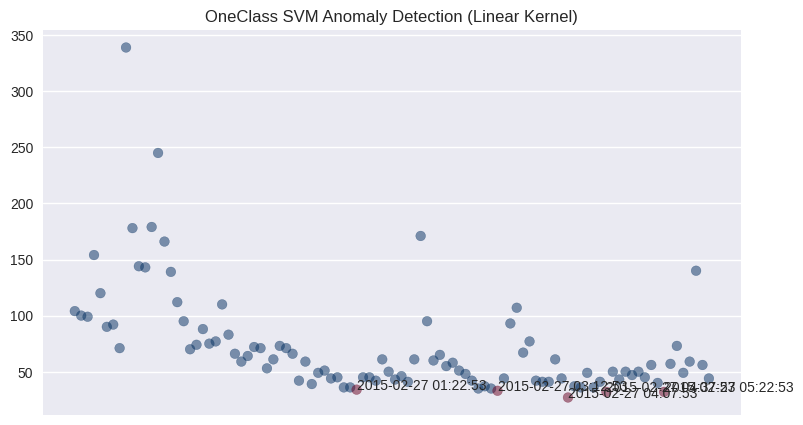

In [52]:
# Contoh penggunaan Linear kernel
model_SVM_linear = OneClassSVM(kernel='linear', nu=0.05)
model_SVM_linear.fit(df[['value']])
df['SVM_anomaly_linear'] = model_SVM_linear.predict(df[['value']])

# Menampilkan Scatter Plot dengan Warna Berdasarkan Anomali (Linear Kernel)
plt.style.use("seaborn")
fig, ax7 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax7.scatter(df['timestamp'], df['value'], c=df['SVM_anomaly_linear'], cmap='RdBu', alpha=0.5)
ax7.set_title("OneClass SVM Anomaly Detection (Linear Kernel)")
for anomaly in df[df['SVM_anomaly_linear'] == -1]['timestamp']:
    ax7.annotate(anomaly, xy=(anomaly, df[df['timestamp'] == anomaly]['value']),
                 xytext=(anomaly, df[df['timestamp'] == anomaly]['value'] + 0.2))
ax7.get_xaxis().set_visible(False)

In [59]:
# Menampilkan jumlah data yang dianggap sebagai anomali
jumlah_anomali_LOF = len(df[df['SVM_anomaly_linear'] == -1])
print(f"Jumlah data anomali berdasarkan OCSVM: {jumlah_anomali_LOF}")

Jumlah data anomali berdasarkan OCSVM: 5
